In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/food41/food_test_c101_n1000_r64x64x3.h5
/kaggle/input/food41/food_c101_n10099_r32x32x3.h5
/kaggle/input/food41/food_c101_n1000_r384x384x3.h5
/kaggle/input/food41/food_test_c101_n1000_r128x128x3.h5
/kaggle/input/food41/food_test_c101_n1000_r32x32x3.h5
/kaggle/input/food41/food_test_c101_n1000_r32x32x1.h5
/kaggle/input/food41/food_test_c101_n1000_r128x128x1.h5
/kaggle/input/food41/food_c101_n10099_r64x64x1.h5
/kaggle/input/food41/food_c101_n10099_r64x64x3.h5
/kaggle/input/food41/food_test_c101_n1000_r64x64x1.h5
/kaggle/input/food41/food_c101_n10099_r32x32x1.h5
/kaggle/input/food41/meta/meta/test.txt
/kaggle/input/food41/meta/meta/train.json
/kaggle/input/food41/meta/meta/labels.txt
/kaggle/input/food41/meta/meta/test.json
/kaggle/input/food41/meta/meta/train.txt
/kaggle/input/food41/meta/meta/classes.txt
/kaggle/input/food41/images/macarons/2428554.jpg
/kaggle/input/food41/images/macarons/3842133.jpg
/kaggle/input/food41/images/macarons/1963752.jpg
/kaggle/input/food41/imag

In [2]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage import segmentation, color
from skimage.filters import gabor
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# ---- Settings ----
DATASET_PATH = "/kaggle/input/food41/images"
CATEGORIES = ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beignets',
              'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche',
              'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla',
              'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros',
              'clam_chowder', 'club_sandwich']
IMAGE_SIZE = 128
MAX_IMAGES_PER_CLASS = 50

from skimage.feature import hog

def extract_features(image):
    features = []

    # --- Gabor Features ---
    gabor_kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        kernel = cv2.getGaborKernel((21, 21), 5.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        gabor_kernels.append(kernel)

    for kernel in gabor_kernels:
        filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
        features.extend(filtered.flatten()[::300])  # Sample to reduce dimensionality

    # --- Color Histogram ---
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0,256, 0,256, 0,256])
    features.extend(hist.flatten())

    # --- HOG Features ---
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(1, 1), feature_vector=True)
    features.extend(hog_feat[:100])  # Use first 100 HOG values to reduce size

    return np.array(features)


# ---- Load Data ----
def load_dataset():
    X, y = [], []
    for label, category in enumerate(CATEGORIES):
        category_path = os.path.join(DATASET_PATH, category)
        if not os.path.exists(category_path):
            continue
        images = os.listdir(category_path)[:MAX_IMAGES_PER_CLASS]
        for img_file in tqdm(images, desc=f"Processing {category}"):
            img_path = os.path.join(category_path, img_file)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
                img = np.array(img)
            except:
                continue
            labels_slic = segmentation.slic(img, compactness=30, n_segments=100)
            superpixels = color.label2rgb(labels_slic, img, kind='avg')
            features = extract_gabor_features((superpixels * 255).astype(np.uint8))
            X.append(features)
            y.append(label)
    return np.array(X), np.array(y)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ---- Main Execution ----
if __name__ == '__main__':
    print("Loading dataset...")
    X, y = load_dataset()

    print("Training SVM classifier...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = SVC(kernel='rbf', C=10, gamma=0.01, probability=True)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=CATEGORIES))


Loading dataset...


Processing club_sandwich: 100%|██████████| 50/50 [00:18<00:00,  2.71it/s]


Training SVM classifier...
Classification Report:
                    precision    recall  f1-score   support

         apple_pie       0.00      0.00      0.00         6
    baby_back_ribs       0.00      0.00      0.00        14
           baklava       0.00      0.00      0.00         7
    beef_carpaccio       0.00      0.00      0.00         6
          beignets       0.00      0.00      0.00        11
      caesar_salad       0.00      0.00      0.00        16
           cannoli       0.00      0.00      0.00        12
     caprese_salad       0.00      0.00      0.00         9
       carrot_cake       0.00      0.00      0.00         8
           ceviche       0.00      0.00      0.00         7
      cheese_plate       0.00      0.00      0.00        12
        cheesecake       0.00      0.00      0.00        10
     chicken_curry       0.00      0.00      0.00        11
chicken_quesadilla       0.00      0.00      0.00        14
     chicken_wings       0.00      0.00      0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Showing segmentation example...


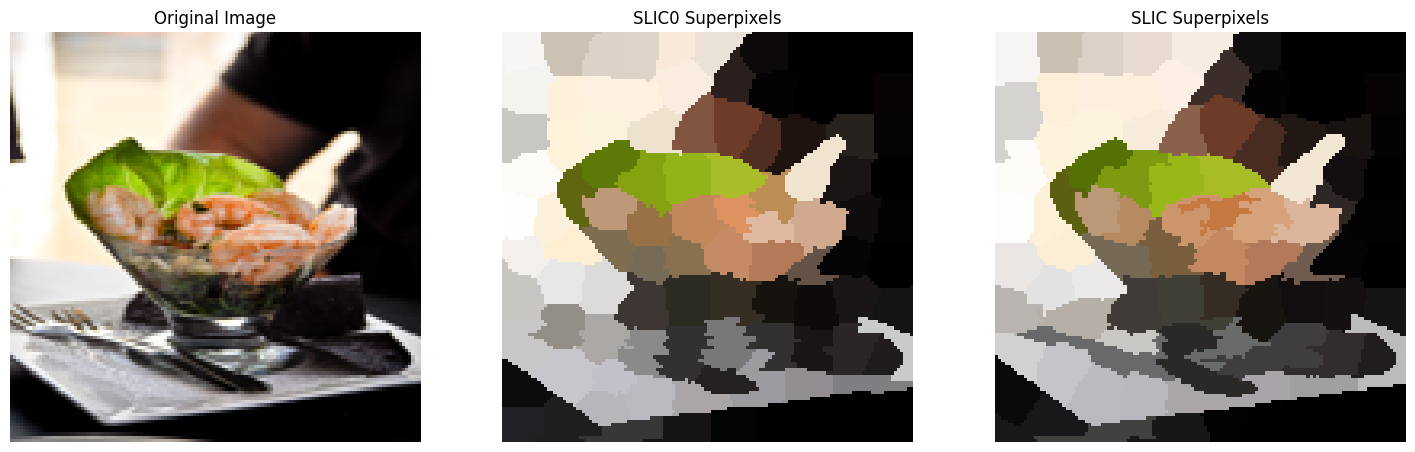

In [3]:
 # Visualize sample segmentations
print("Showing segmentation example...")
sample_category = 'ceviche'
sample_img_path = os.path.join(DATASET_PATH, sample_category, os.listdir(os.path.join(DATASET_PATH, sample_category))[0])

img = Image.open(sample_img_path).convert('RGB')
img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
img = np.array(img)
labels_slic0 = segmentation.slic(img, slic_zero=True)
superpixels_slic0 = color.label2rgb(labels_slic0, img, kind='avg')
labels_slic = segmentation.slic(img, compactness=30, n_segments=100)
superpixels_slic = color.label2rgb(labels_slic, img, kind='avg')

plt.figure(figsize=(18, 14))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(superpixels_slic0)
plt.title("SLIC0 Superpixels")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(superpixels_slic)
plt.title("SLIC Superpixels")
plt.axis('off')
plt.show()

In [4]:
# ---- Predict the class of the visualized image ----
seg_features = extract_gabor_features((superpixels_slic * 255).astype(np.uint8))
pred_class = clf.predict([seg_features])[0]
pred_label = CATEGORIES[pred_class]

print(f"Predicted class for displayed image: {pred_label}")


Predicted class for displayed image: ceviche
